# Experiments on NME

Import libraries

In [30]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as interp
import collections
import math
import copy
sys.path.insert(0, '../ReSurfEMG')
import helper_functions as hf
from config import Config


In [31]:
emg_sample_rate = 999
from scipy.io import loadmat
mat = loadmat('out1.mat')
data_emg_samples = mat['out']
data_emg_samples = np.array(data_emg_samples)
data_emg_samples[0]

array([ 2.82756601,  8.81642003, 15.12477701, ..., -4.18096841,
       -3.99636279, -1.4839238 ])

Now you can pick a file from the list, which have been numbered.

[Text(0.5, 1.0, 'leads in EMG in sec')]

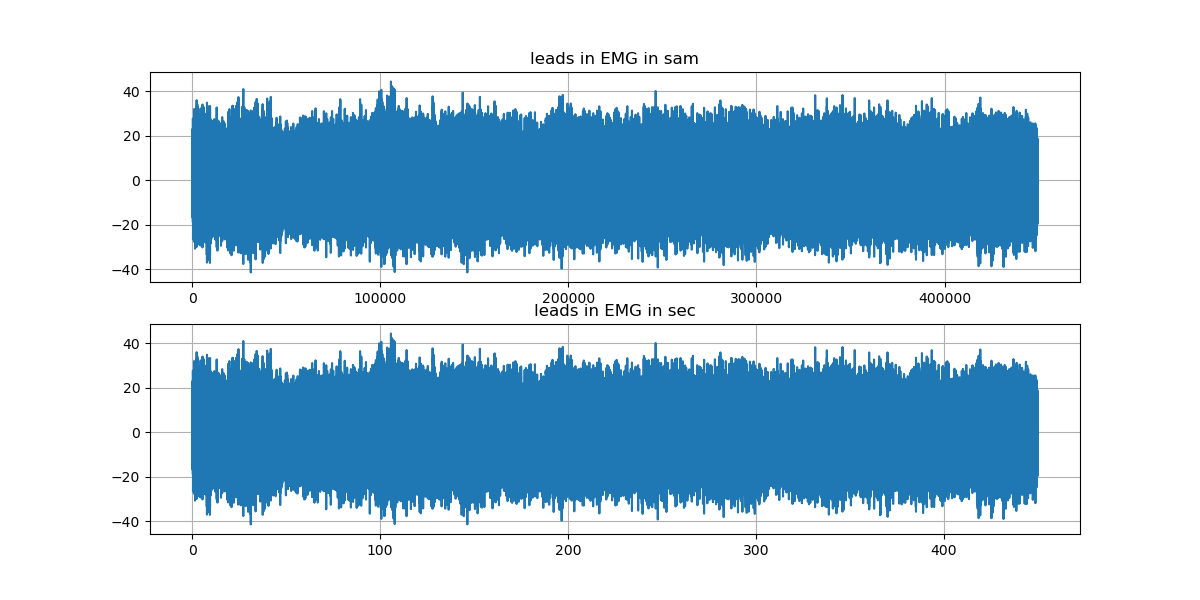

In [32]:
x_emg = copy.deepcopy(data_emg_samples)

y_emg = [i/emg_sample_rate for i in range(len(data_emg_samples[0]))]

fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
axis[0].grid(True)
axis[0].plot(x_emg[0])
axis[0].set(title='leads in EMG in sam')
#axis[1, 0].plot(x_emg[1])

axis[1].grid(True)
axis[1].plot(y_emg, x_emg[0])
axis[1].set(title='leads in EMG in sec')
#axis[1, 1].plot(y_emg, x_emg[1])


In [33]:
# type in start number and press return for it to update
start = input()

In [34]:
# type in end number and press return for it to update
end = input()

In [35]:
time_view = 'Seconds'

[Text(0.5, 1.0, 'leads in EMG')]

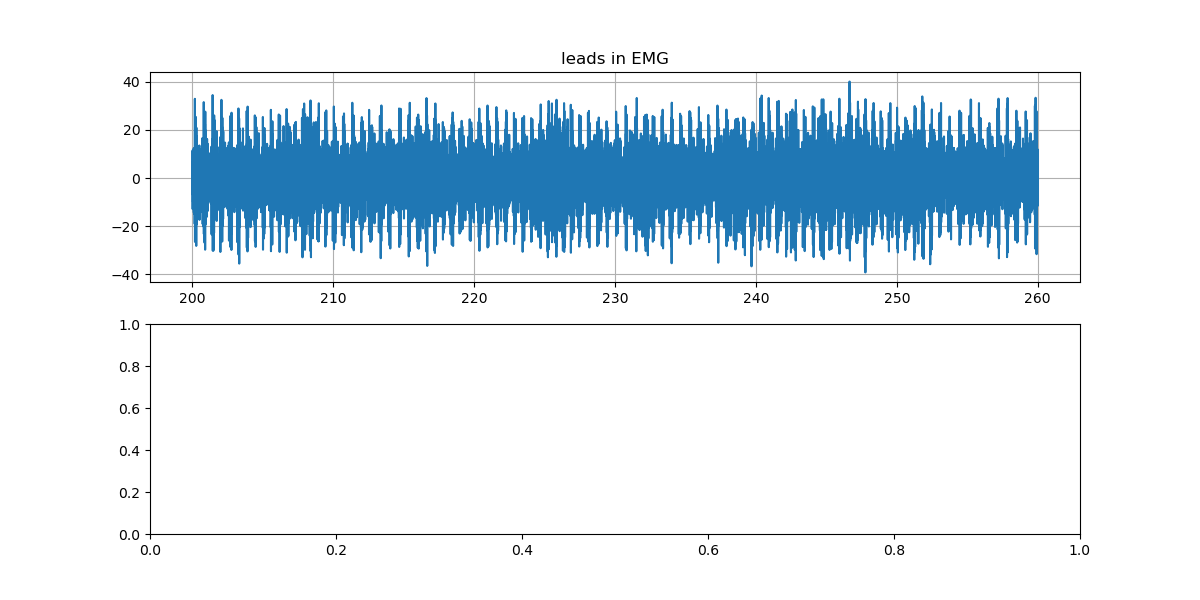

In [36]:
if time_view == 'Seconds':
    start_s = int(float(start)* emg_sample_rate)
    end_s = min([int(float(end)*emg_sample_rate), len(data_emg_samples[0])-1])

else:
    start_s = int(float(start))
    end_s = min([int(float(end)), len(data_emg_samples[0])-1])
    y_emg = [range(len(data_emg_samples[0]))]

# nox examine at a certain scale- from point a to b as samples
fig, axis = plt.subplots(nrows=2, figsize=(12, 6))
axis[0].grid(True)
axis[0].plot(y_emg[int(start_s):int(end_s)], x_emg[0][int(start_s):int(end_s)])
axis[0].set(title='leads in EMG')
#axis[1].plot(y_emg[int(start_s):int(end_s)], x_emg[1][int(start_s):int(end_s)])


Happy with your selection? If not redo, then we can see how the filter works on it.

# Pre-processing pipeline

In [37]:
fs = 999

In [45]:
# processed_data_emg_di = working_pipeline_pre_entropy(data_emg_samples)
bd_filtered_file_data = hf.emg_bandpass_butter_sample(data_emg_samples, 1, 450, fs, output='sos')
processed_data_ecg = bd_filtered_file_data[0, start_s:end_s]
processed_data_emg_di = bd_filtered_file_data[0, start_s:end_s]

y_emg = [i/emg_sample_rate for i in range(len(data_emg_samples[0]))]
y_emg = y_emg[start_s:end_s]

In [48]:
plot_window = 5

# Detect ECG peaks on 1Hz high-pass filtered signals
peak_width = 0.01
peak_fraction = 0.4
ecg = processed_data_ecg
ecg_rms = hf.full_rolling_rms(ecg,10)
peak_height = peak_fraction*(max(ecg_rms[0:int(plot_window*emg_sample_rate)]) - min(ecg_rms[0:int(plot_window*emg_sample_rate)]))

ECG_peaks, properties  = scipy.signal.find_peaks(ecg_rms, height=peak_height, width=peak_width*emg_sample_rate)


# Filter EXG signals 20Hz high pass
ECG_h20 = hf.emg_bandpass_butter_sample(ecg, 20, 450, fs, output='sos')
emg_di_h20 = hf.emg_bandpass_butter_sample(processed_data_emg_di, 20, 450, fs, output='sos')

# Gate ECG and EMG signal
gate_width = 0.005
gate_fill_method = 3    # 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 3: Moving average
gate_width_samples = int(gate_width*emg_sample_rate)

ECG_gated = hf.gating(ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=gate_fill_method)
emg_di_gated = hf.gating(emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=gate_fill_method)

# Example of all methods
emg_di_gated_zero = hf.gating(emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=0)
emg_di_gated_interpolate = hf.gating(emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=1)
emg_di_gated_prior_ave = hf.gating(emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=2)
emg_di_gated_MA = hf.gating(emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3) # Default


Plot gated signal

Text(0.5, 0, 't (s)')

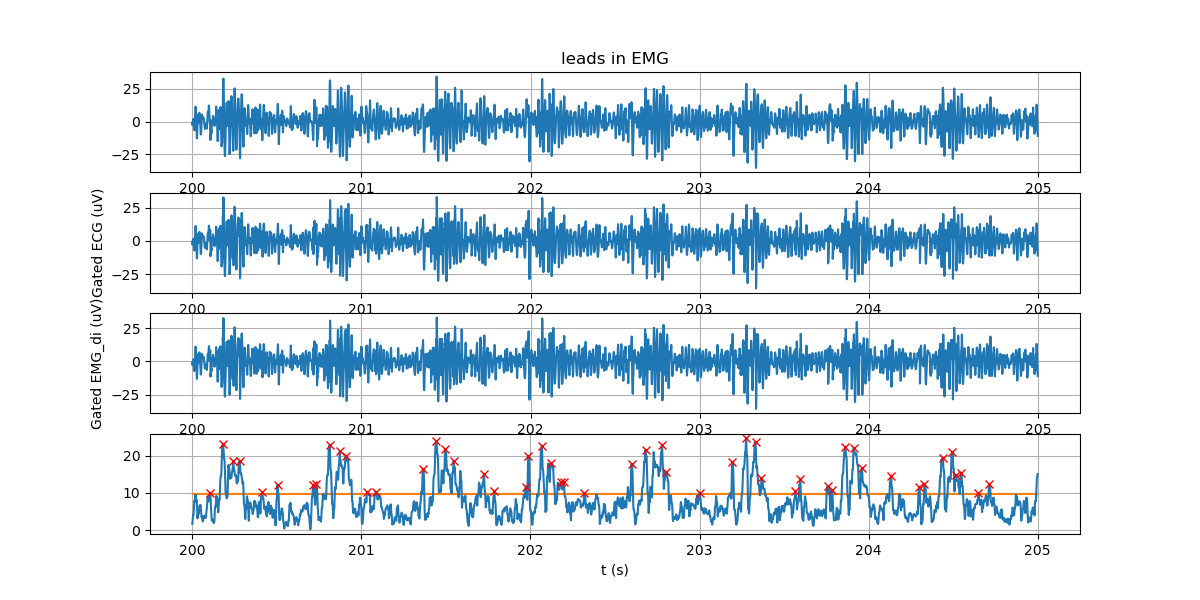

In [49]:

fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
axis[0].grid(True)
axis[0].plot(y_emg[0:int(+plot_window*fs)], bd_filtered_file_data[0, int(start_s):int(start_s+plot_window*fs)])
axis[1].set_ylabel('Source ECG (uV)')

axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(y_emg[0:int(plot_window*fs)], ECG_gated[0:int(plot_window*fs)])
axis[1].set_ylabel('Gated ECG (uV)')
# axis[1].plot(y_emg[int(start_s):int(start_s+plot_window*2048)], ECG_gated_RMS[int(start_s):int(start_s+plot_window*2048)])
axis[2].grid(True)
axis[2].plot(y_emg[0:int(plot_window*fs)], emg_di_gated[0:int(plot_window*fs)])
# axis[2].plot(y_emg[int(start_s):int(start_s+plot_window*2048)], emg_gated_RMS[int(start_s):int(start_s+plot_window*2048)])
axis[2].set_ylabel('Gated EMG_di (uV)')

axis[3].grid(True)
axis[3].plot(y_emg[0:int(plot_window*fs)], ecg_rms[0:int(plot_window*fs)])
axis[3].hlines(y=peak_height, xmin=y_emg[0], xmax=y_emg[int(plot_window*fs)], color = "C1")
for idx in range(len(ECG_peaks)):
    if  (ECG_peaks[idx] < int(plot_window*fs)):
        axis[3].plot(y_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')

axis[3].set_xlabel('t (s)')

Calculate RMS

In [56]:
RMS_window_ms = 600
RMS_windows_samp = int(RMS_window_ms / 1000 *  emg_sample_rate)

RMS_data_emg_di = hf.full_rolling_rms(emg_di_gated, RMS_windows_samp)

RMS_data_emg_di_zero = hf.full_rolling_rms(emg_di_gated_zero, RMS_windows_samp)
RMS_data_emg_di_interpolate = hf.full_rolling_rms(emg_di_gated_interpolate, RMS_windows_samp)
RMS_data_emg_di_prior_ave = hf.full_rolling_rms(emg_di_gated_prior_ave, RMS_windows_samp)
RMS_data_emg_di_MA = hf.full_rolling_rms(emg_di_gated_MA, RMS_windows_samp)

Plot RMS signals

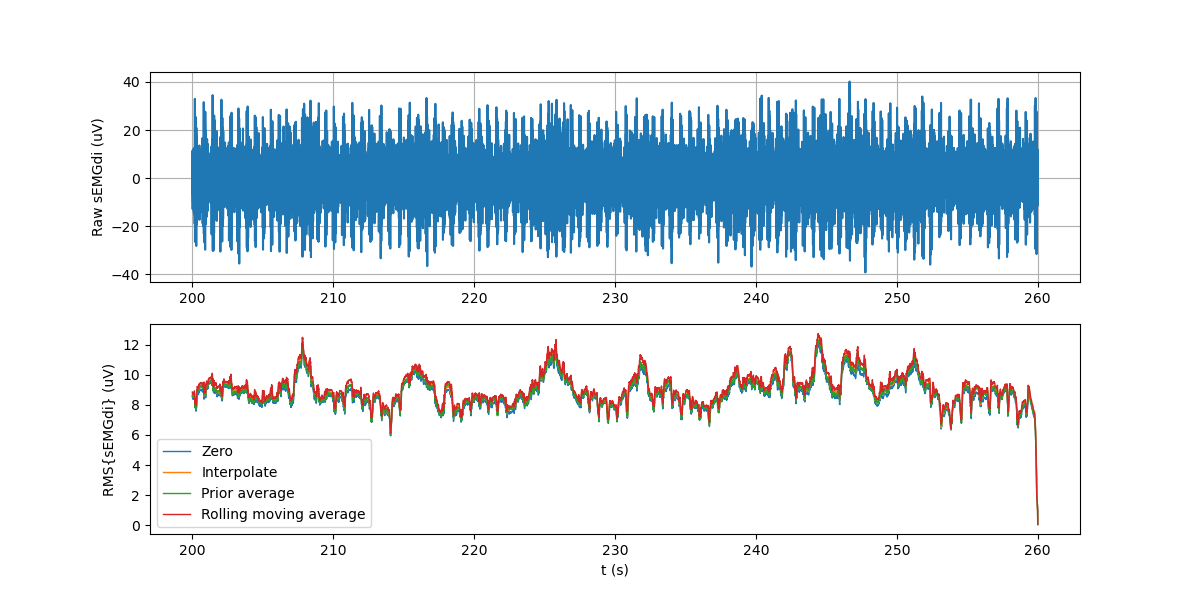

In [57]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
axis[0].grid(True)
axis[0].plot(y_emg, processed_data_emg_di)
axis[0].set_ylabel('Raw sEMGdi (uV)')

axis[1].plot(y_emg, RMS_data_emg_di_zero, linewidth=1)
axis[1].plot(y_emg, RMS_data_emg_di_interpolate, linewidth=1)
axis[1].plot(y_emg, RMS_data_emg_di_prior_ave, linewidth=1)
axis[1].plot(y_emg, RMS_data_emg_di_MA, linewidth=1)
axis[1].set_xlabel('t (s)')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].legend(['Zero', 'Interpolate', 'Prior average', 'Rolling moving average'])



In [58]:
RMS_data_emg_di_prior_ave = RMS_data_emg_di_prior_ave - np.mean(RMS_data_emg_di_prior_ave)